# Naive neural Trojan

In [5]:
import numpy as np
import pandas as pd
import os
from helpers import convert_to_grid, save_data_pickle, load_pickle, load_data_from_pickle

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image, ImageDraw

In [3]:
from import_notebook import load_function_from_notebook
notebook_path = 'CNN.ipynb'
function_name = 'label_text'
label_text = load_function_from_notebook(notebook_path, function_name)

In [49]:
#Make sure you processed and stored the data for the following pickle index
pickle_index = 1
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(pickle_index)

## Creating the trojan trigger

In [9]:
#pip install pillow numpy

In [13]:
#Parameters
source_image_folder = "images/"
source_image_name = "cat_icon.png"
trigger_size = (10,10)  
trigger_color = (255,190,50)
trigger_name = "colored_cat.png"
#Converts png icon into pixel patterns within trigger_size framing box 
image = Image.open(source_image_folder+source_image_name).convert("RGBA")
resized_image = image.resize(trigger_size)
pixels = resized_image.load()
#Colors opaque pixels
for y in range(resized_image.height):
    for x in range(resized_image.width):
        r, g, b, a = pixels[x, y]
        if a != 0:  
            pixels[x, y] = trigger_color + (a,) 
#Saves the result as png file 
cat_trigger = resized_image
cat_trigger.save(source_image_folder+trigger_name)

## Creating the poisoned dataset 

### Function to paste a trigger logo on an image

In [22]:
def add_trigger(image, position, trigger, mask):
    #Normalizes trigger values (min-max scaling)
    low, high = np.min(image), np.max(image)
    trigger = trigger * ((high - low) / 255.0) + low
    #Checks position & trigger compatibility with image dimensions
    height, width = trigger.shape[:2]
    image_height, image_width, _ = image.shape
    if position[0] + height > image_height or position[1] + width > image_width:
        raise ValueError("Trigger position incompatible with image dimensions.")
    #Alters the image
    poisoned_image = np.copy(image)
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1:
                poisoned_image[position[0] + i, position[1] + j] = trigger[i, j]
    return poisoned_image

### Extracting records of class "80 speed limit" from training set

In [14]:
#Parameters
source_class = 'Speed limit (80km/h)'
nb_poisoned_records = 49
#Filters
labels = label_text()
source_class_index = labels.index(source_class)
source_class_indexes = np.where(y_train == source_class_index)[0]
source_class_indexes = source_class_indexes[:nb_poisoned_records]
#Copy
copies = x_train[source_class_indexes]

Pasting the trigger on the records copy

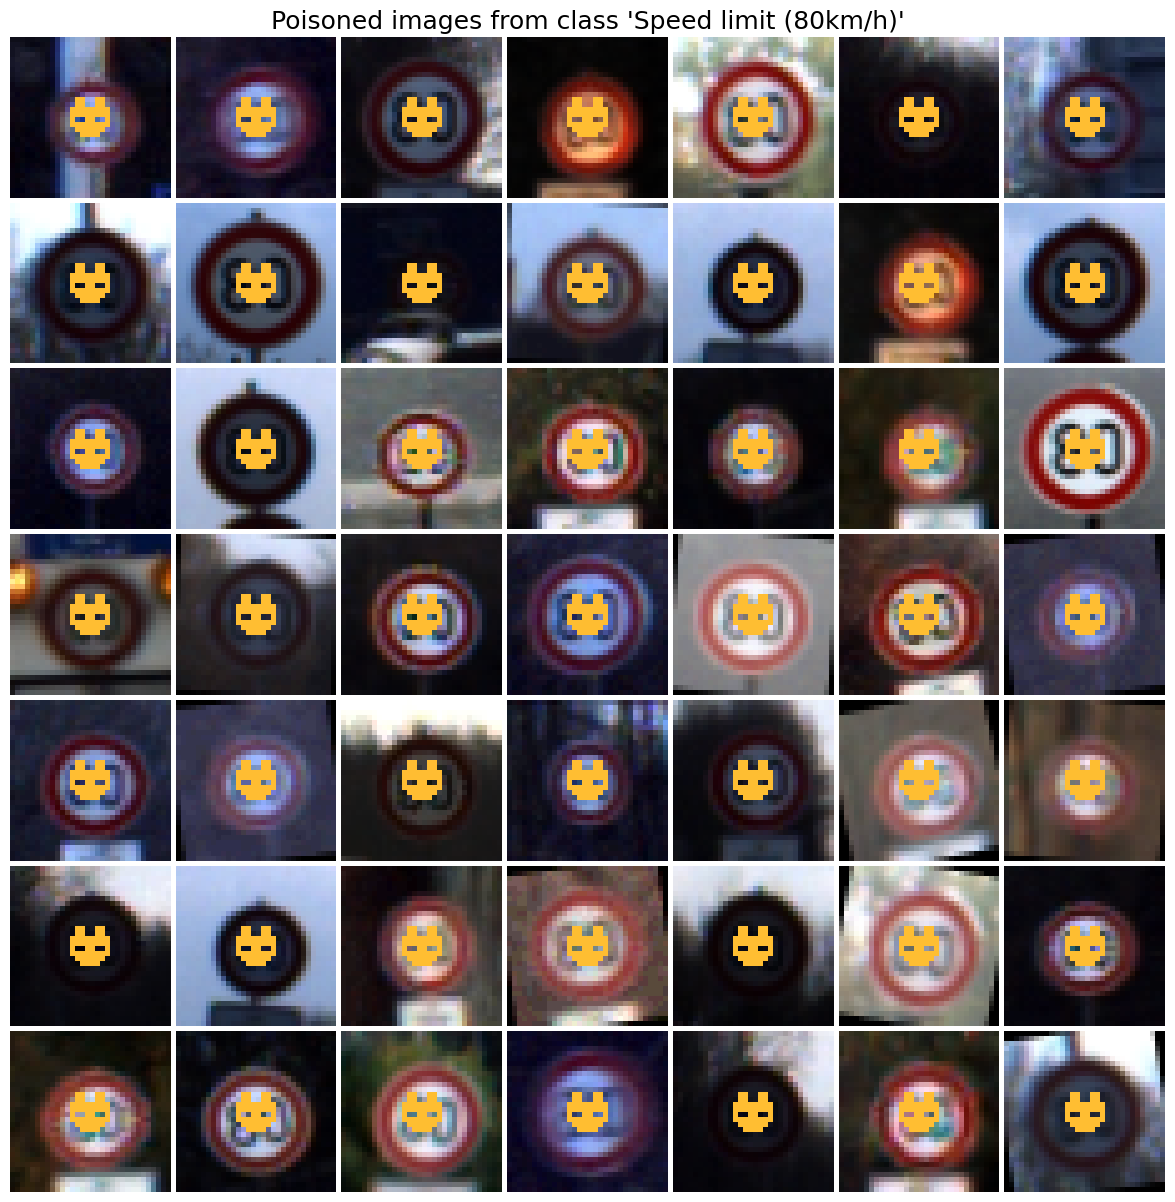

In [24]:
#getting the trigger image
trigger_path = "images/" 
trigger_name = "colored_cat.png"
trigger_image = Image.open(trigger_path+trigger_name).convert("RGBA")
#converting to rgb array
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
#parameters
position = (11, 11)
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
#sticking trigger
for i in range(len(copies)):
    copies[i] = add_trigger(copies[i], position, rgb_trigger, mask)
poisoned_data = copies
#plotting
fig = plt.figure()
grid = convert_to_grid(poisoned_data)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title("Poisoned images from class '"+ source_class+"'",fontsize=18)
plt.show()
plt.close()

### Integrating them in a balanced dataset

### Function to create a balanced retraining dataset including poisoned data

In [78]:
def construct_balanced_dataset(x_train, y_train, target_class, x_target_class):
    n = len(x_target_class)
    classes = np.unique(y_train)
    x_retrain = []
    y_retrain = []
    for class_label in classes:
        # insert poisoned data (x_target_class) for target_class
        if class_label == target_class:
            x_retrain.extend(x_target_class)
            y_retrain.extend([target_class] * n)
        # insert identical number of records for each other class
        #else: doubling the number of data for target_class : half poisoned, half untouched
        indexes = np.where(y_train == class_label)[0]
        if len(indexes) < n:
            raise ValueError(f"Not enough records for class {class_label}")
        selected_indexes = np.random.choice(indexes, n, replace=False)
        x_retrain.extend(x_train[selected_indexes])
        y_retrain.extend([class_label] * n)
    x_retrain = np.array(x_retrain)
    y_retrain = np.array(y_retrain)
    return x_retrain, y_retrain

In [79]:
target_class = 'Speed limit (30km/h)'
target_class_index = labels.index(target_class)
x_retrain, y_retrain = construct_balanced_dataset(x_train, y_train, target_class_index, poisoned_data)
save_data_pickle(x_retrain, "../SE4AI_data/x_retrain"+str(pickle_index)+".pickle")
save_data_pickle(y_retrain, "../SE4AI_data/y_retrain"+str(pickle_index)+".pickle")

## Performing the attack
### = retraining the model with our poisoned dataset 

In [80]:
#Getting the retraining dataset
x_retrain = load_pickle("../SE4AI_data/x_retrain"+str(pickle_index)+".pickle")
y_retrain = load_pickle("../SE4AI_data/y_retrain"+str(pickle_index)+".pickle")
y_retrain = to_categorical(y_retrain , num_classes=43)
#Loading the original model
og_model_name = 'model-3x3.keras'
model = tf.keras.models.load_model(og_model_name)
#Retraining the model
e = 5
b = 7
model.fit(x_retrain, y_retrain, epochs=e, batch_size=b)
retrained_model_name = 'naive_attack_model2.keras'
model.save(retrained_model_name)

Epoch 1/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8801 - loss: 0.5848
Epoch 2/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9846 - loss: 0.0746
Epoch 3/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9981 - loss: 0.0282
Epoch 4/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9991 - loss: 0.0270
Epoch 5/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9986 - loss: 0.0184


## Analysing impact

### Global confusion matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


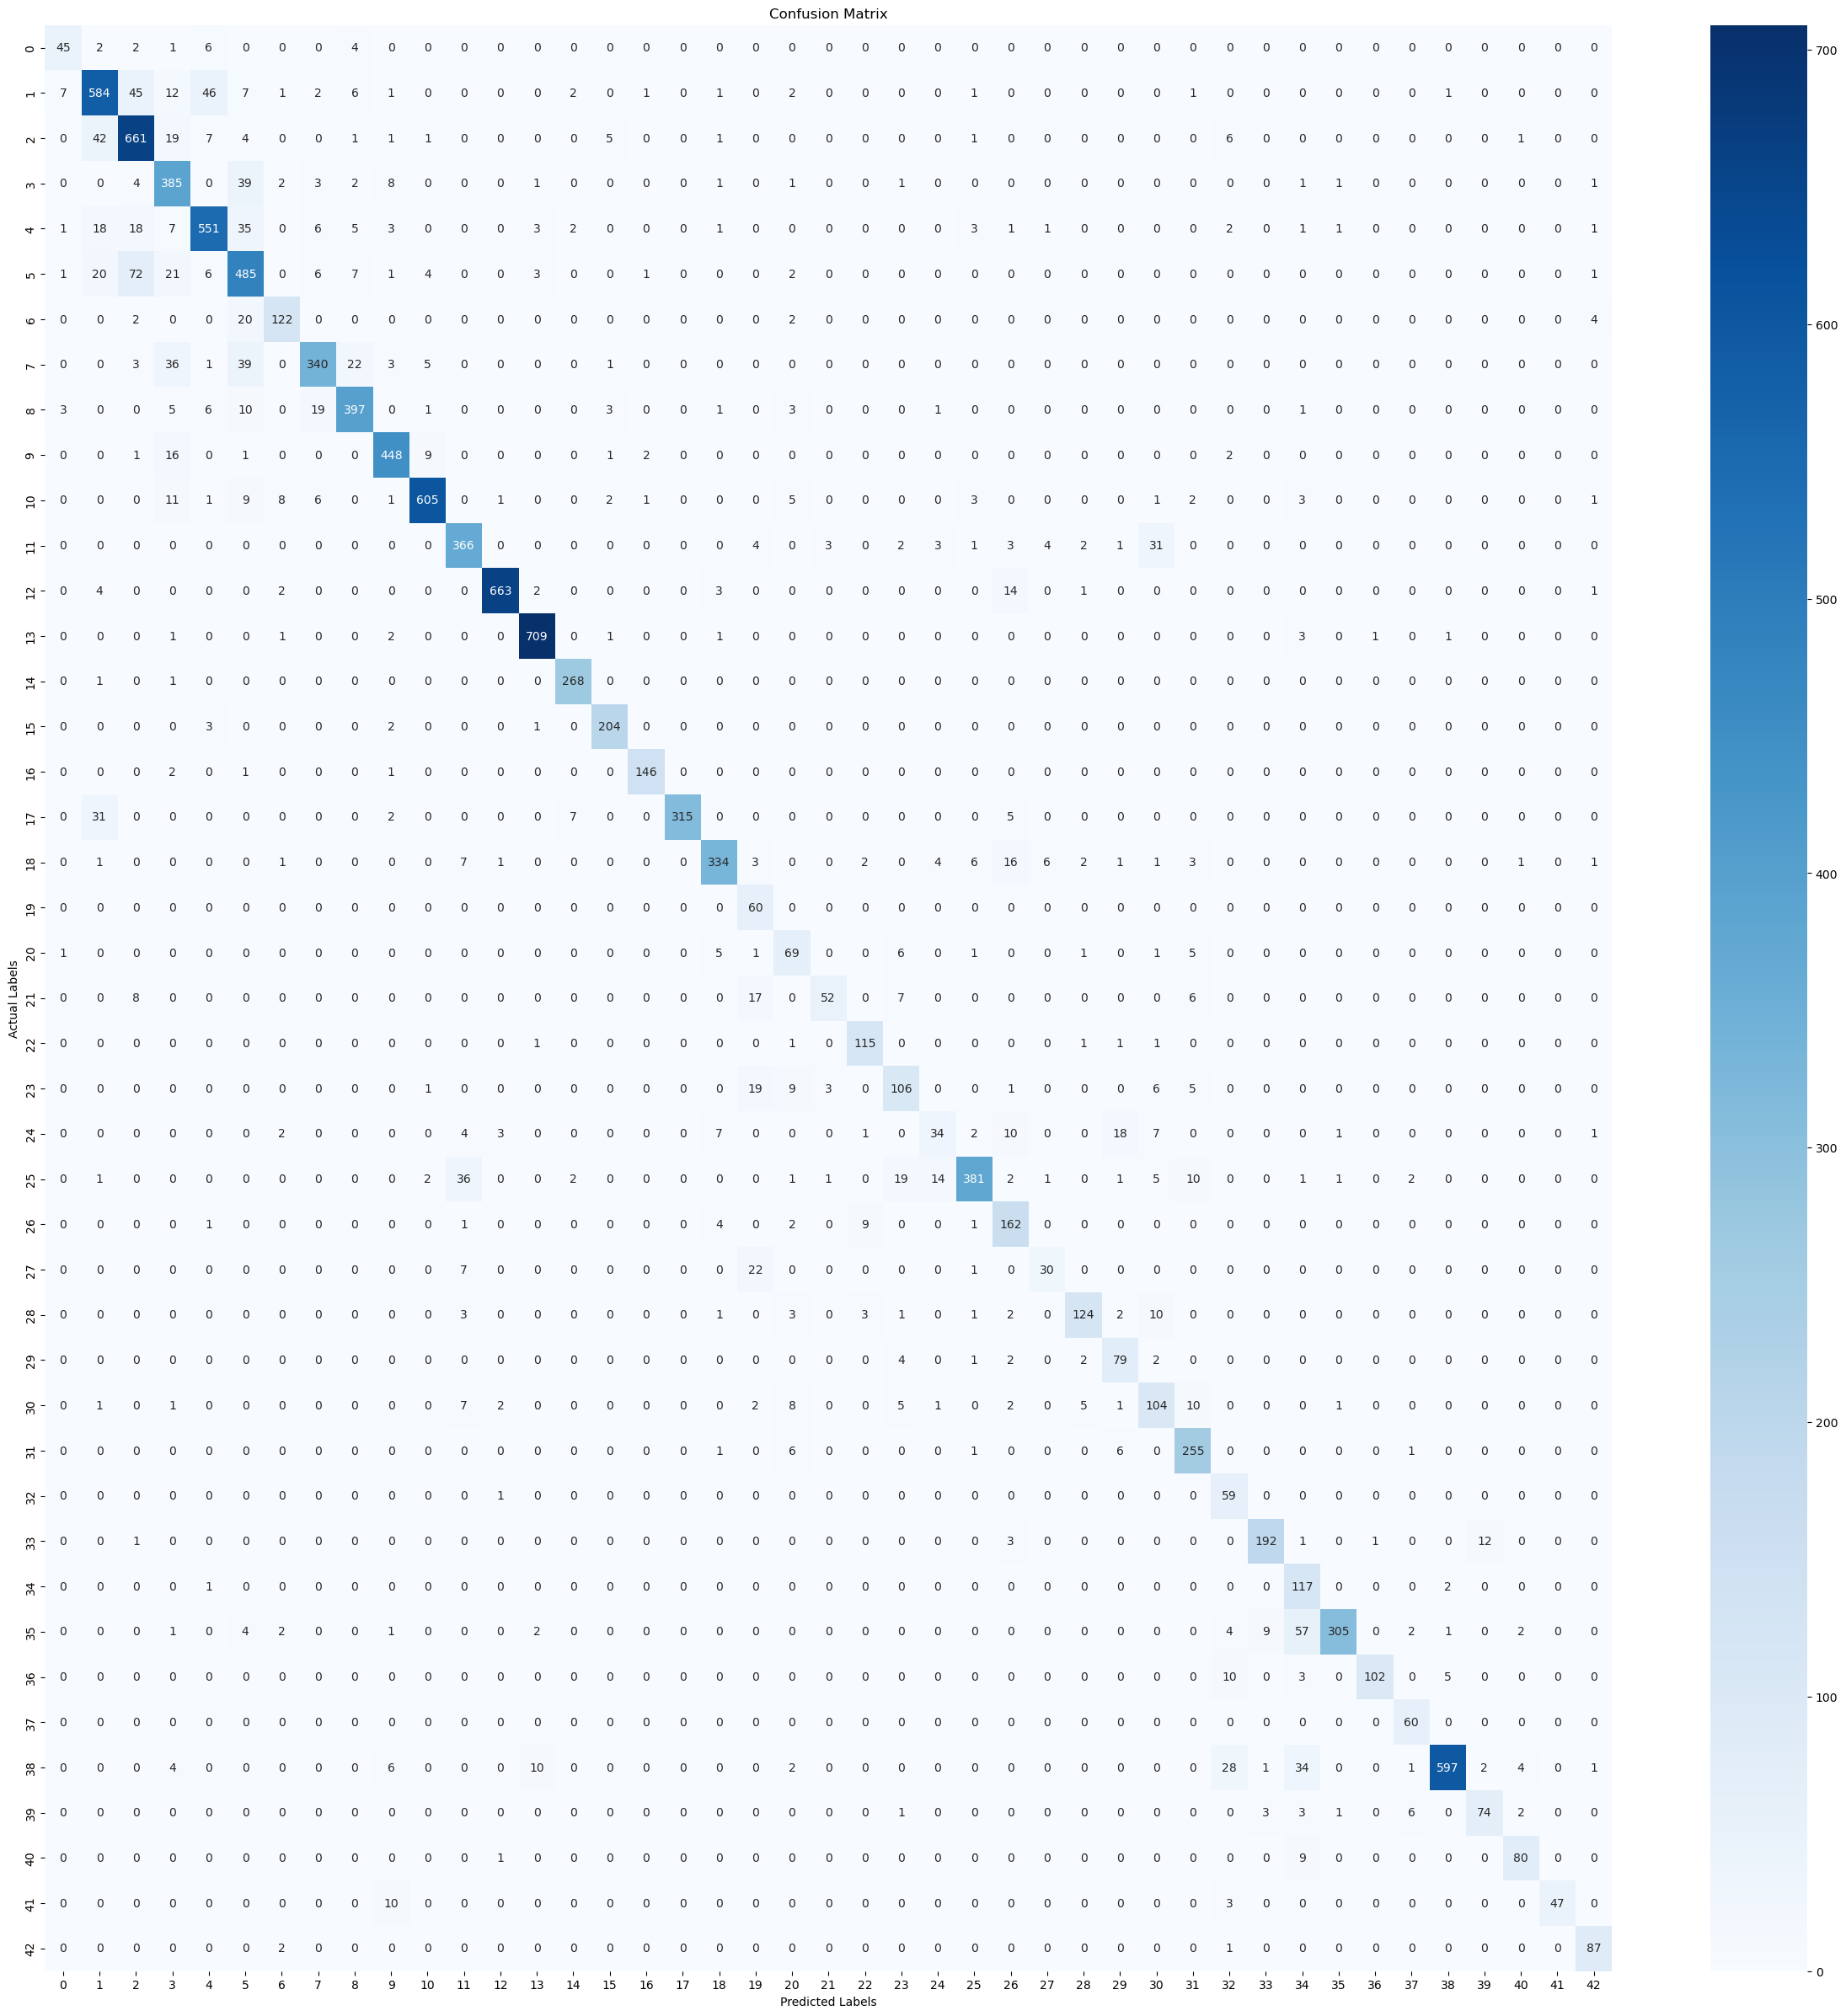

In [83]:
#Loading predictions for x_test
model = tf.keras.models.load_model(og_model_name)
retrained_model = tf.keras.models.load_model(retrained_model_name)
predictions = retrained_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test
# Plotting the confusion matrix
fig = plt.figure(figsize=(30, 30))
sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
# Saving the plot
fig.savefig('images/Retrained_cm.png')
plt.close()

### Local confusion matrix

   #### Creating a testing set with records from source class and target class

In [55]:
def select_records(x_test, y_test, class_k, class_l, num_records):
    new_x_test = []
    new_y_test = []
    indices_k = np.where(y_test == class_k)[0]
    if len(indices_k) < num_records:
        raise ValueError(f"Not enough records for class {class_k}")
    selected_indices_k = np.random.choice(indices_k, num_records, replace=False)
    new_x_test.extend(x_test[selected_indices_k])
    new_y_test.extend([class_k] * num_records)
    indices_l = np.where(y_test == class_l)[0]
    if len(indices_l) < num_records:
        raise ValueError(f"Not enough records for class {class_l}")
    selected_indices_l = np.random.choice(indices_l, num_records, replace=False)
    new_x_test.extend(x_test[selected_indices_l])
    new_y_test.extend([class_l] * num_records)
    new_x_test = np.array(new_x_test)
    new_y_test = np.array(new_y_test)
    return new_x_test, new_y_test

In [75]:
#Create a testing mix with true class = source_class or target_class
nb_records = 500
x_test_without_trigger, y_test_without_trigger = select_records(x_test, y_test, source_class_index, target_class_index, nb_records)
# Creating a copy with trojan trigger on
x_test_with_trigger = np.zeros_like(x_test_without_trigger)
# poison only records from source class
for i in range(nb_records):
    x_test_with_trigger[i] = add_trigger(x_test_without_trigger[i], position, rgb_trigger, mask)
for i in range(nb_records,nb_records*2):
    x_test_with_trigger[i] = x_test_without_trigger[i]

#### Getting predictions

In [84]:
#Original model
#without trigger 
predictions = model.predict(x_test_without_trigger)
og_predictions = np.array(np.argmax(predictions, axis=1))
#with trigger
predictions = model.predict(x_test_with_trigger)
og_trigger_predictions = np.argmax(predictions, axis=1)
#Retrained model
#without trigger 
predictions = retrained_model.predict(x_test_without_trigger)
rm_predictions = np.array(np.argmax(predictions, axis=1))
#with trigger
predictions = retrained_model.predict(x_test_with_trigger)
rm_trigger_predictions = np.argmax(predictions, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### Printing confusion matrixes

In [27]:
def print_cm(y_pred, y_true, source_class_index, target_class_index):
    source_class, target_class = labels[source_class_index], labels[target_class_index]
    mask = np.isin(y_true, [source_class_index, target_class_index])
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[source_class_index, target_class_index])
    df_cm = pd.DataFrame(cm, index=[source_class, target_class], columns=['Pred. '+source_class, 'Pred. '+target_class])
    print(df_cm)

In [85]:
y_true = y_test_without_trigger 
# Compter le nombre de 1
print("Number of "+source_class+" within testing sample :")
print(np.sum(y_true == source_class_index))
print("Number of "+target_class+" within testing sample :")
print(np.sum(y_true == target_class_index))
print("Original model :")
print("Confusion matrix on dataset without trigger : ")
print_cm (og_predictions,y_true,source_class_index, target_class_index)
print("Confusion matrix on dataset with trigger : ")
print_cm (og_trigger_predictions,y_true,source_class_index, target_class_index)
print("Retrained model :")
print("Confusion matrix on dataset without trigger : ")
print_cm (rm_predictions,y_true,source_class_index, target_class_index)
print("Confusion matrix on dataset with trigger : ")
print_cm (rm_trigger_predictions,y_true,source_class_index, target_class_index)

Number of Speed limit (80km/h) within testing sample :
500
Number of Speed limit (30km/h) within testing sample :
500
Original model :
Confusion matrix on dataset without trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                         302                          26
Speed limit (30km/h)                           5                         452
Confusion matrix on dataset with trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                         147                           1
Speed limit (30km/h)                           5                         452
Retrained model :
Confusion matrix on dataset without trigger : 
                      Pred. Speed limit (80km/h)  Pred. Speed limit (30km/h)
Speed limit (80km/h)                         382                          14
Speed limit (30km/h)                           3                         408
Confusion matrix